In [1]:
import pandas as pd
import numpy as np
import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
from KDEpy import FFTKDE
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from array import array
%matplotlib inline

In [2]:
user_freetext_desktop = pd.read_csv('C:/Research Activities/Dataset/BB-MAS_Dataset/Desktop_Freetext.csv', header=0)
key_distance = pd.read_excel('C:/Research Activities/Dataset/Keyboard_distance.xlsx')

In [3]:
user_1_desktop = pd.read_csv('C:/Research Activities/Dataset/BB-MAS_Dataset/1/1_Desktop_Keyboard.csv', header=0)
user_2_desktop = pd.read_csv('C:/Research Activities/Dataset/BB-MAS_Dataset/2/2_Desktop_Keyboard.csv', header=0)

In [4]:
user_freetext_desktop['timestamp'] = pd.to_datetime(user_freetext_desktop['timestamp'])
user_1_desktop['time'] = pd.to_datetime(user_1_desktop['time'])
user_2_desktop['time'] = pd.to_datetime(user_2_desktop['time'])

In [5]:
user_1_fixedtext_desktop = user_1_desktop[user_1_desktop["time"]< (user_freetext_desktop.iloc[0,1])]
user_1_freetext_desktop = user_1_desktop[user_1_desktop["time"]>= (user_freetext_desktop.iloc[0,1])]

user_2_fixedtext_desktop = user_2_desktop[user_2_desktop["time"]< (user_freetext_desktop.iloc[1,1])]
user_2_freetext_desktop = user_2_desktop[user_2_desktop["time"]>= (user_freetext_desktop.iloc[1,1])]

In [6]:
def get_timings_KIT(keys_in_pipeline, search_key, search_key_timing):
    mask = np.ones(len(keys_in_pipeline))
    keys_in_pipeline = np.asarray(keys_in_pipeline)
    for i, (key, timing) in enumerate(keys_in_pipeline):
          if(search_key==key):
            mask[i] = 0
            non_zero_indices = np.nonzero(mask) 

            if(len(non_zero_indices)>0):
                keys_in_pipeline = keys_in_pipeline[non_zero_indices]
            else:
                  keys_in_pipeline = []

            return keys_in_pipeline, timing, search_key_timing
    return keys_in_pipeline, None, None

# function to get KIT data frame with key, press_time, release_time for a given user
def get_dataframe_KIT(data):
    """ Input: data  Output: Dataframe with (key, press_time, release_time)""" 
    
    keys_in_pipeline = []
    result_key = []
    press = []
    release = []
    for row_idx in range(len(data)):
        keys_in_pipeline = list(keys_in_pipeline)
        curr_key = data[row_idx][1]
        curr_direction = data[row_idx][2]
        curr_timing = data[row_idx][3]

        if(curr_direction==0):
            keys_in_pipeline.append([curr_key, curr_timing])

        if(curr_direction==1):
            keys_in_pipeline, curr_start, curr_end = get_timings_KIT(keys_in_pipeline, curr_key, curr_timing)
            if(curr_start is None):
                continue
            else:
                result_key.append(curr_key)
                press.append(curr_start)
                release.append(curr_end)

    resultant_data_frame = pd.DataFrame(list(zip(result_key, press, release)),
               columns =['Key', 'Press_Time', 'Release_Time']) 
    return resultant_data_frame  

In [7]:
def get_DIG_features(data):
  
    result = [{'Keys': str(data[row_idx][0])+','+str(data[row_idx + 1][0]), 
               'Holdtime1': (((data[row_idx][2]-data[row_idx][1])).microseconds)/1000,
            'Holdtime2': (((data[row_idx + 1][2]-data[row_idx + 1][1])).microseconds)/1000,
               'F1': (((data[row_idx+1][1]-data[row_idx][2])).microseconds)/1000,
              'F2': (((data[row_idx+1][1]-data[row_idx][1])).microseconds)/1000,
              'F3': (((data[row_idx+1][2]-data[row_idx][2])).microseconds)/1000,
              'F4': (((data[row_idx+1][2]-data[row_idx][1])).microseconds)/1000} 
              for row_idx in range(0, len(data)) 
              if (row_idx + 1 < len(data))]
        
    df = pd.DataFrame(result)
    
    return df

In [8]:
df_desktop_user1_fixed = get_dataframe_KIT(user_1_fixedtext_desktop.values)
df_desktop_user2_fixed = get_dataframe_KIT(user_2_fixedtext_desktop.values)

df_desktop_user1_free = get_dataframe_KIT(user_1_freetext_desktop.values)
df_desktop_user2_free = get_dataframe_KIT(user_2_freetext_desktop.values)

In [9]:
df_desktop_user1_fixed_features = get_DIG_features(df_desktop_user1_fixed.values)
df_desktop_user2_fixed_features = get_DIG_features(df_desktop_user2_fixed.values)

df_desktop_user1_free_features = get_DIG_features(df_desktop_user1_free.values)
df_desktop_user2_free_features = get_DIG_features(df_desktop_user2_free.values)

In [10]:
df_desktop_user1_fixed_features["F1"].describe()

count    2357.000000
mean      188.667374
std       197.952558
min        14.000000
25%        78.000000
50%       124.000000
75%       202.000000
max       998.000000
Name: F1, dtype: float64

In [11]:
df_combine_user1_fixed = df_desktop_user1_fixed_features.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_fixed = df_desktop_user2_fixed_features.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)

df_combine_user1_free = df_desktop_user1_free_features.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)
df_combine_user2_free = df_desktop_user2_free_features.join(key_distance.set_index('Keys'), on='Keys', 
                                                              how='inner').sort_index(axis=0, ascending=True)

In [12]:
df_user_1_fixed_1_distance = df_combine_user1_fixed.loc[(df_combine_user1_fixed['Hands']!='LR') & 
                                                        (df_combine_user1_fixed['Distance']==1)] 
df_user_2_fixed_1_distance = df_combine_user2_fixed.loc[(df_combine_user2_fixed['Hands']!='LR') & 
                                                        (df_combine_user2_fixed['Distance']==1)] 

df_user_1_free_1_distance = df_combine_user1_free.loc[(df_combine_user1_free['Hands']!='LR') & 
                                                        (df_combine_user1_free['Distance']==1)]
df_user_2_free_1_distance = df_combine_user2_free.loc[(df_combine_user2_free['Hands']!='LR') & 
                                                        (df_combine_user2_free['Distance']==1)]

In [13]:
df_user_1_fixed_1_distance.count()

Keys         289
Holdtime1    289
Holdtime2    289
F1           289
F2           289
F3           289
F4           289
Distance     289
Hands        289
dtype: int64

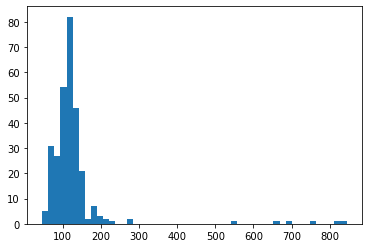

In [14]:
plt.hist(df_user_1_fixed_1_distance['F1'], bins=50)
plt.show()

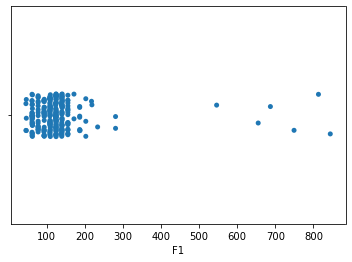

In [15]:
sns.stripplot(data= df_user_1_fixed_1_distance, x='F1')
plt.show()

In [16]:
x_train,x_test = train_test_split(df_user_1_fixed_1_distance['F1'], test_size=0.4, random_state=10)

In [17]:
x = np.sort(np.array(x_train))[:, np.newaxis]

In [18]:
y = np.sort(np.array(x_test))[:, np.newaxis]

In [19]:
model = KernelDensity()
model.fit(x)
log_dens = model.score_samples(y)

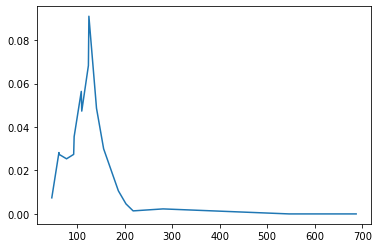

In [20]:
plt.plot(y,np.exp(log_dens))
plt.show()

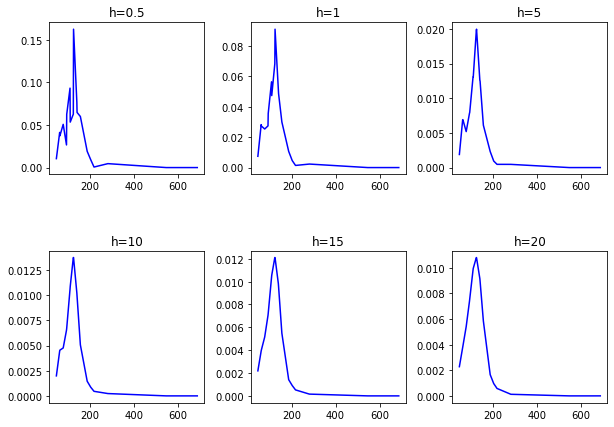

In [21]:
bandwidths = [ 0.5, 1, 5, 10,15, 20]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231

for b, ind in zip(bandwidths, plt_ind):
    kde_model = KernelDensity(kernel='gaussian', bandwidth=b)
    kde_model.fit(x)
    score = kde_model.score_samples(y)
    plt.subplot(ind)
    plt.plot(y, np.exp(score), c='blue')
    plt.title("h="+str(b))

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

C:\Users\s3929438\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
C:\Users\s3929438\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
C:\Users\s3929438\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf]
  warnings.warn(
C:\Users\s3929438\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:929: Runtime

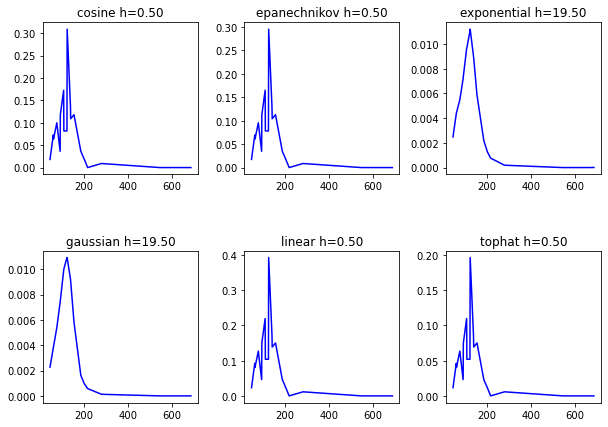

In [22]:
kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231
h_vals = np.arange(0.5, 20, 0.5)

for k, ind in zip(kernels, plt_ind):
        grid = GridSearchCV(KernelDensity(kernel=k),
                        {'bandwidth': h_vals})
        grid.fit(x)
        kde = grid.best_estimator_
        log_dens = kde.score_samples(y)
        plt.subplot(ind)
        plt.plot(y, np.exp(log_dens), c='blue')
        plt.title(k + " h=" + "{:.2f}".format(kde.bandwidth))

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

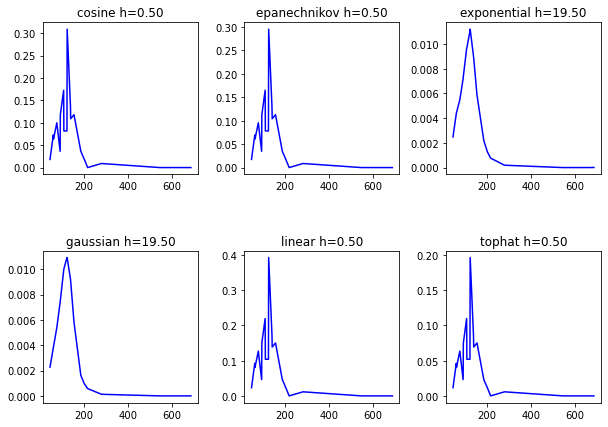

In [23]:
def my_scores(estimator, X):
    scores = estimator.score_samples(X)
    
    scores = scores[scores != float('-inf')]
    
    return np.mean(scores)

kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231
h_vals = np.arange(0.5, 20, 0.5)

for k, ind in zip(kernels, plt_ind):
        grid = GridSearchCV(KernelDensity(kernel=k),
                        {'bandwidth': h_vals},
                        scoring=my_scores)
        grid.fit(x)
        kde = grid.best_estimator_
        log_dens = kde.score_samples(y)
        plt.subplot(ind)
        plt.plot(y, np.exp(log_dens), c='blue')
        plt.title(k + " h=" + "{:.2f}".format(kde.bandwidth))

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

In [1]:
kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
h_vals = np.arange(1, 20, 0.5)
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': h_vals, 'kernel': kernels},
                    scoring=my_scores)
grid.fit(x)
best_kde = grid.best_estimator_
log_dens = best_kde.score_samples(y)
plt.plot(y, np.exp(log_dens), c='green')
plt.title("Best Kernel: " + best_kde.kernel+" h="+"{:.2f}".format(best_kde.bandwidth))
plt.show()

NameError: name 'np' is not defined

C:\Users\s3929438\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  -313.01591267 -5776.39904815
           -inf           -inf]
  warnings.warn(
C:\Users\s3929438\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


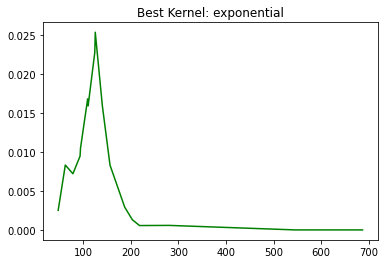

In [25]:
grid = GridSearchCV(KernelDensity(bandwidth=5),
                    { 'kernel': kernels})
grid.fit(x)
best_kde = grid.best_estimator_
log_dens = best_kde.score_samples(y)
plt.plot(y, np.exp(log_dens), c='green')
plt.title("Best Kernel: " + best_kde.kernel)
plt.show()

In [26]:
def kl_divergence(p, q):
    if len(p)>len(q):
        p = p[0:len(q)]
    elif len(q)>len(p):
        q = q[0:len(p)]
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

In [27]:
x1 = np.sort(np.array(df_user_1_fixed_1_distance['F1']))[:, np.newaxis]
kde_model = KernelDensity(kernel='exponential', bandwidth=5)
kde_model.fit(x1)
score1 = kde_model.score_samples(x1)
y1 = np.exp(score1)

In [28]:
x2 = np.sort(np.array(df_user_1_fixed_1_distance['F1']))[:, np.newaxis]
de_model = KernelDensity(kernel='exponential', bandwidth=5)
kde_model.fit(x2)
score2 = kde_model.score_samples(x2)
y2 = np.exp(score2)

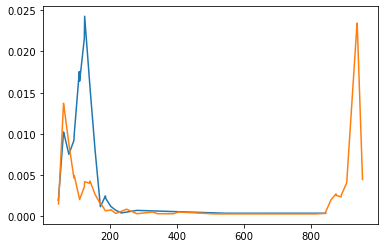

In [29]:
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.show()

In [30]:
kl_divergence(y1,y2)

6.02330148454776

In [31]:
x1 = np.sort(np.array(df_user_1_free_1_distance['F1']))[:, np.newaxis]
kde_model1 = KernelDensity(kernel='exponential', bandwidth=5)
kde_model1.fit(x1)
score1 = kde_model1.score_samples(x1)
y1 = np.exp(score1)
y1_sorted = np.sort(y1)

In [32]:
x2 = np.sort(np.array(df_user_2_free_1_distance['F1']))[:, np.newaxis]
kde_model2 = KernelDensity(kernel='exponential', bandwidth=5)
kde_model2.fit(x2)
score2 = kde_model2.score_samples(x2)
y2 = np.exp(score2)

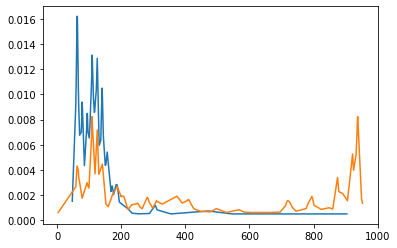

In [33]:
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.show()

In [34]:
kl_divergence(y1,y2)

2.6035100183441773

In [35]:
kl_values= []
for i in range(1,50):
    x1 = np.sort(np.array(df_user_1_fixed_1_distance['F1']))[:, np.newaxis]
    kde_model = KernelDensity(kernel='exponential', bandwidth=i)
    kde_model.fit(x1)
    score1 = kde_model.score_samples(x1)
    y1 = np.exp(score1)
    x2 = np.sort(np.array(df_user_2_fixed_1_distance['F1']))[:, np.newaxis]
    kde_model = KernelDensity(kernel='exponential', bandwidth=i)
    kde_model.fit(x2)
    score2 = kde_model.score_samples(x2)
    y2 = np.exp(score2)
    kl = kl_divergence(y1,y2)
    kl_values.append(kl)

In [36]:
kl_values

[23.5797722271476,
 12.984088842141787,
 9.117466941410726,
 7.1632902208258145,
 6.02330148454776,
 5.290151679847282,
 4.781224326385015,
 4.405420507375595,
 4.113652779858386,
 3.877786097010379,
 3.6808413068910895,
 3.5121102432376476,
 3.3645747060620232,
 3.233473652008092,
 3.1154735817764583,
 3.0081707829575874,
 2.909783593334303,
 2.818957224181647,
 2.734637166475988,
 2.655985361618535,
 2.582323546932626,
 2.5130941458910874,
 2.4478326493336655,
 2.3861476345677186,
 2.327705950707885,
 2.272221477147524,
 2.219446422743286,
 2.16916448875515,
 2.121185440846784,
 2.075340772701256,
 2.031480228796613,
 1.9894690083166773,
 1.94918550952436,
 1.9105195018323216,
 1.8733706351323132,
 1.837647214406036,
 1.8032651829657063,
 1.7701472702152286,
 1.7382222698781435,
 1.707424422534899,
 1.6776928823970583,
 1.6489712528727014,
 1.621207178960117,
 1.5943519871206957,
 1.568360365240122,
 1.5431900767666622,
 1.5188017042397761,
 1.4951584182879616,
 1.4722257688527238]

In [37]:
data = np.sort(np.array(df_user_1_fixed_1_distance['F1']))[:, np.newaxis]
x1, y1 = FFTKDE(kernel='exponential', bw='ISJ').fit(data).evaluate()

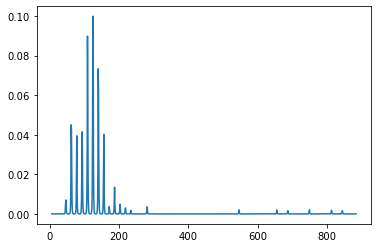

In [38]:
plt.plot(x1,y1)
plt.show()

In [39]:
data = np.sort(np.array(df_user_2_fixed_1_distance['F1']))[:, np.newaxis]
x2, y2 = FFTKDE(kernel='exponential', bw='ISJ').fit(data).evaluate()

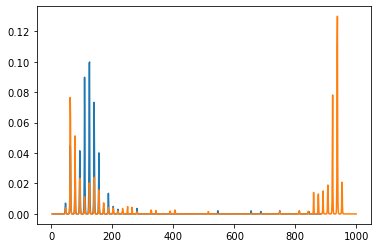

In [40]:
plt.plot(x1,y1)
plt.plot(x2,y2)
plt.show()

In [41]:
kl_divergence(y1,y2)

13.213701974326987